# Symbolic Regression with Genetic Programming

Date: 2021-01-11  
Categories: julia, evolutionary  
Tags: symbolic regression, genetic programming
<!--eofm-->

## Introduction

**Symbolic Regression** is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset, both in terms of accuracy and simplicity. While conventional regression techniques seek to optimize the parameters for a pre-specified model structure, symbolic regression avoids imposing prior assumptions, and instead infers the model from the data. Common representation of the SR model is an expression tree.

- An example of the expression tree for $x^3+x^2+x$

![](Expression_Tree.png)

**Genetic Programming (GP)** evolves computer programs, traditionally represented as expression tree structures.  Some of the applications of GP are curve fitting, data modeling, symbolic regression, feature selection, classification, etc. 
<!--more-->

## Benchmark Function

We begin by importing some Julia libraries

In [1]:
using Evolutionary
using Random
using Plots
Plots.gr()
default(fmt = :png)

┌ Info: Precompiling Evolutionary [86b6b26d-c046-49b6-aa0b-5f0f74682bd6]
└ @ Base loading.jl:1273


We need to generate some data from **Nguyen-1** benchmark function: $x^3+x^2+x$

In [2]:
Random.seed!(42);
d, n = 1, 20
Nguyen1(x) = x*x*x + x*x + x
xs = sort!(2*rand(n).-1)

20-element Array{Float64,1}:
 -0.9646263465700713 
 -0.6799878057158164 
 -0.6541339421260974 
 -0.6461828007342891 
 -0.4743823295397043 
 -0.3922607778264351 
 -0.27308315609588885
 -0.2330176105940942 
 -0.1540874689837164 
 -0.09194172882571516
  0.00590422275549729
  0.06636603208772263
  0.16856829512576077
  0.18582314647694176
  0.20459516053276605
  0.49036263858165396
  0.8749326091650076 
  0.9138316481785176 
  0.9178517526594696 
  0.9471319596073715 

Next, we define collection of symbols and operations used for construction of of the genetic program expression.

First, we define the symbols

In [3]:
syms = [:x]

1-element Array{Symbol,1}:
 :x

and, the allowed functions

In [4]:
funcs = Function[+, -, *, /]

4-element Array{Function,1}:
 +
 -
 *
 /

Let's define the fitness function for evaluation of the genetic program as root-mean-square error (RMSE)

In [5]:
fitobj(expr) = sum( abs2.(Nguyen1.(xs) - Evolutionary.Expression(expr).(xs)) )/length(xs) |> sqrt

fitobj (generic function with 1 method)

Test some arbitrary expression with our fitness function

In [6]:
expr = Expr(:call, *, :x, :x)
println("Evaluate expression: ", Evolutionary.Expression(expr).(xs))
println("Obj. func = ", fitobj(expr))

Evaluate expression: [0.9305039884971232, 0.4623834159222109, 0.42789121424142856, 0.41755221196481, 0.22503859457951658, 0.15386851782099986, 0.0745744101432916, 0.054297206846980924, 0.02374294809780776, 0.008453281499461342, 3.4859846346532014e-5, 0.004404450215068629, 0.028415270121605583, 0.034530241766590954, 0.04185917971342831, 0.2404555173167618, 0.7655070705802879, 0.835088281212666, 0.8424518398600602, 0.8970589489096996]
Obj. func = 0.9660246588120451


Now, we use `TreeGP` optimization  algorithm that will construct a symbolic solution for 

In [7]:
Random.seed!(987498737423);
res = Evolutionary.optimize(fitobj,
    TreeGP(50, Terminal[syms...], funcs,
        mindepth=1,
        maxdepth=4,
        optimizer = GA(
            selection = uniformranking(5),
            ɛ = 0.1,
            mutationRate = 0.95,
            crossoverRate = 0.05,
        ),
    )
)


 * Status: success

 * Candidate solution
    Minimizer:  (+)((*)(x, (+)((*)(x, x), x)), x)
    Minimum:    3.5652682413747996e-17
    Iterations: 20

 * Found with
    Algorithm: TreeGP[P=50,Parameter[x],Function[*, +, /, -]]


We can generate minimizing expression in LaTeX format 

In [8]:
Evolutionary.minimizer(res) |> Evolutionary.Expression

((x*((x*x)+x))+x)

The minimizing expression
$$\left(\left(x*\left(\left(x*x\right)+x\right)\right)+x\right)$$

## Symbolic Regression

### Linear

We generate a dataset to work with

In [9]:
Random.seed!(42);
n = 50
xs = range(-20, 20, length=n) |> collect
ys = (rand(n).*0.8.+0.3).*xs + (rand(n).*5.0.+2.0)
xs, ys

([-20.0, -19.183673469387756, -18.367346938775512, -17.551020408163264, -16.73469387755102, -15.918367346938776, -15.10204081632653, -14.285714285714286, -13.46938775510204, -12.653061224489797  …  12.653061224489797, 13.46938775510204, 14.285714285714286, 15.10204081632653, 15.918367346938776, 16.73469387755102, 17.551020408163264, 18.367346938775512, 19.183673469387756, 20.0], [-10.301775957695707, -10.233893692226244, -0.5108186849245042, -4.548650362389421, -11.37884481662021, -13.45714316027289, -3.411883269164912, -1.6257189913947885, -7.9511271443853495, -4.779000246208424  …  9.182787509211524, 19.30856201963916, 19.363218214500648, 11.01307966019218, 18.25693527098487, 8.264341990912298, 24.771086256895913, 18.58907728951158, 24.017965869842424, 19.200868554184602])

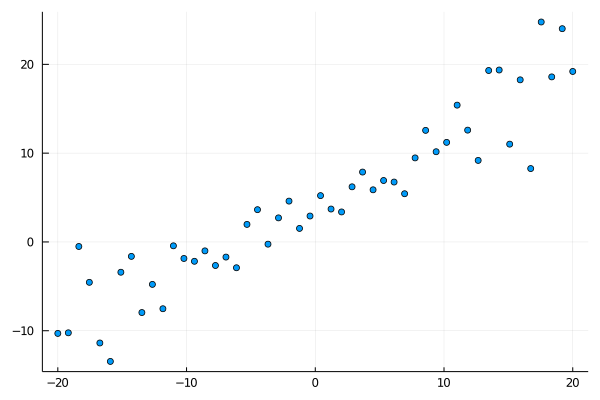

In [10]:
scatter(xs, ys, leg=:none)

Define our objective function and test it with an arbitrary exression

In [11]:
fitobj(expr) = sum( abs2.(ys - Evolutionary.Expression(expr).(xs)) ) |> sqrt

expr = Expr(:call, *, :x, :x)
println("Obj. func = ", fitobj(expr))

Obj. func = 1290.672514731313


We need to the symbol collection `rand` function which will alow to generate numerical constanst in addition to the symbolical variables. For each symbol we specify its arity.

In [12]:
syms = Dict(:x=>1, (rand) => 1)

Dict{Any,Int64} with 2 entries:
  rand => 1
  :x   => 1

We define linear operations, and provide their arity.

In [13]:
funcs = Dict((+) => 2, (-) => 2,  (*) => 2, (/) => 2)

Dict{Function,Int64} with 4 entries:
  * => 2
  + => 2
  / => 2
  - => 2

We also need to increase maximum depth for the expression tree to accommodate more complex expressions

In [14]:
Random.seed!(987498737423);
res = Evolutionary.optimize(fitobj,
    TreeGP(
        populationSize = 500,
        terminals = syms,
        functions = funcs,
        mindepth=1,
        maxdepth=3,
        initialization=:full,
        optimizer = GA(
            selection = uniformranking(2),
            mutationRate = 0.1,
            crossoverRate = 0.95,
            ɛ = 0.001
        ),
    ),
    Evolutionary.Options(iterations=50, show_trace=true, show_every=10)
)

Iter     Function value
     0              0.0
 * time: 0.016000986099243164
    10   23.070150702286064
 * time: 0.5699429512023926
    20   23.050119363563365
 * time: 0.8840680122375488



 * Status: success

 * Candidate solution
    Minimizer:  (-)((+)((/)(0.7443415808289588, 0.2519046833943326), (*)(x, 0.7443415808289588)), (-)((-)(x, 0.7443415808289588), (+)(x, 0.7443415808289588)))
    Minimum:    23.050119363563365
    Iterations: 29

 * Found with
    Algorithm: TreeGP[P=500,Parameter[x],Function[*, +, /, -]]


Here is our minimizing expression

In [15]:
ex = Evolutionary.Expression(Evolutionary.minimizer(res))

(((0.744/0.252)+(x*0.744))-((x-0.744)-(x+0.744)))

Calculate least squares solution for comparison

In [16]:
X = hcat(ones(n), xs)
β = inv(X'X)*X'ys

2-element Array{Float64,1}:
 4.467274179301777 
 0.7300600401251902

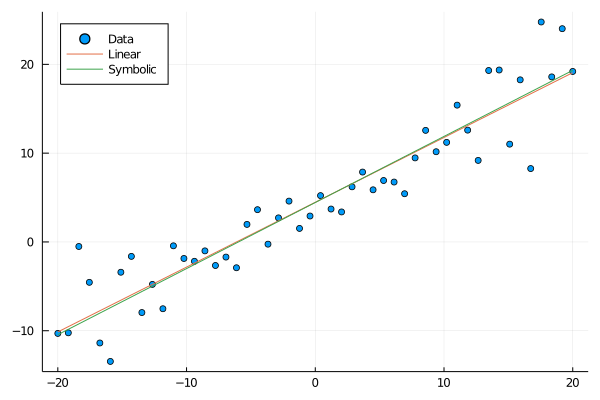

In [17]:
scatter(xs, ys, label="Data", legend=:topleft)
plot!(xs, β[2].*(xs).+β[1], label="Linear")
plot!(xs, ex.(xs), label="Symbolic")

### Nonlinear

Now, let's generate some noisy with nonlinear data

In [18]:
Random.seed!(42);
xs = collect(0:0.1:2*pi) |> sort!
ys = sin.(xs) + cos.(xs + xs) .+ randn(length(xs))./2
xs, ys

([0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9  …  5.300000000000001, 5.4, 5.5, 5.6000000000000005, 5.7, 5.800000000000001, 5.9, 6.0, 6.1000000000000005, 6.2], [0.7219865619268069, 0.8577083159332218, 1.1333079938025434, 0.9711137763915625, 1.9750556006844782, 0.44727707860793275, 0.6926972867878716, 0.8922565614583021, -0.6328389354401641, 1.0577797656641383  …  -1.4019731481680853, -1.2610491311786165, -0.25605035540673443, -0.3085504793933047, -0.2547580599017927, 0.43075074590266565, -0.06247315632300754, -0.2608450734190263, 0.5449753531328724, 0.9167487102317231])

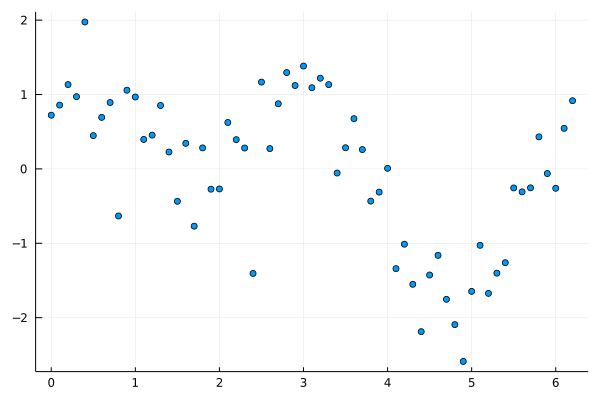

In [19]:
scatter(xs, ys, leg=:none)

We also expend the function collection with `sin`, `cos`, `log`,  and `exp`. We also provide arity for each function.

In [20]:
funcs = Dict((+) => 2, (-) => 2,  (*) => 2, (/) => 2,
             (sin) => 1, (cos) => 1)
             #(^)=>2, (log) => 1, (exp) => 1)

Dict{Function,Int64} with 6 entries:
  *   => 2
  +   => 2
  sin => 1
  /   => 2
  -   => 2
  cos => 1

We also need to increase maximum depth for the expression tree to accommodate more complex expressions

In [21]:
Random.seed!(9874987374243);
res = Evolutionary.optimize(fitobj,
    TreeGP(
        populationSize = 1000,
        terminals = syms,
        functions = funcs,
        mindepth=1,
        maxdepth=4,
        initialization=:grow,
        optimizer = GA(
            selection = uniformranking(5),
            mutationRate = 0.1,
            crossoverRate = 0.8,
            ɛ = 0.001
        ),
    ),
    Evolutionary.Options(iterations=60, show_trace=true, show_every=15)
)

Iter     Function value
     0              0.0
 * time: 0.00010800361633300781
    15   4.072232948324664
 * time: 0.41045403480529785



 * Status: success

 * Candidate solution
    Minimizer:  (+)((cos)((+)(x, x)), (sin)((sin)(x)))
    Minimum:    4.072232948324664
    Iterations: 16

 * Found with
    Algorithm: TreeGP[P=1000,Parameter[x],Function[*, +, sin, /, -, cos]]


Here is the resulting expression, and the plot of this expression evaluated on the original data.

- The resulting expression is very close to the original data-generating function, $\sin(x) + \cos(x + x) + \varepsilon$. 

In [22]:
ex = Evolutionary.Expression(Evolutionary.minimizer(res) |> copy)

(cos((x+x))+sin(sin(x)))

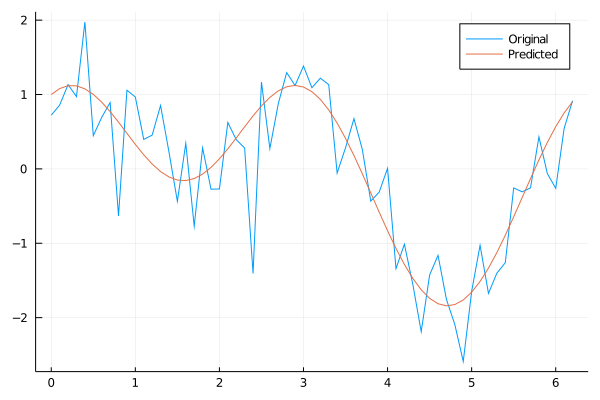

In [23]:
plot(xs, ys, label="Original")
plot!(xs, ex.(xs), label="Predicted")

### Expression Simplification 

However, sometimes, the generated expression can be quite long

In [24]:
Random.seed!(987498737424);
res = Evolutionary.optimize(fitobj,
    TreeGP(
        populationSize = 500,
        terminals = syms,
        functions = funcs,
        mindepth=1,
        maxdepth=5,
        initialization=:grow,
        optimizer = GA(
            selection = uniformranking(2),
            mutationRate = 0.15,
            crossoverRate = 0.8,
            ɛ = 0.001
        ),
    ),
    Evolutionary.Options(iterations=50, show_trace=true, show_every=15)
)

Iter     Function value
     0              0.0
 * time: 9.202957153320312e-5
    15   4.928502370610355
 * time: 0.717289924621582
    30   4.7741079939719295
 * time: 2.1325550079345703



 * Status: success

 * Candidate solution
    Minimizer:  (cos)((-)((+)((*)((-)((+)((*)((*)((-)((+)((+)((*)((-)((+)((*)((*)((-)((+)((*)((*)((-)(0.9450845364794724, x), 0.9450845364794724), 0.9450845364794724), (cos)(0.9450845364794724)), 0.9450845364794724), 0.9450845364794724), 0.9450845364794724), (cos)(0.9450845364794724)), 0.9450845364794724), (sin)(x)), (cos)(0.9450845364794724)), (cos)(0.9450845364794724)), 0.9450845364794724), 0.9450845364794724), 0.9450845364794724), (cos)(0.9450845364794724)), 0.9450845364794724), (sin)(x)), (cos)(0.9450845364794724)), 0.9450845364794724))
    Minimum:    4.7741079939719295
    Iterations: 41

 * Found with
    Algorithm: TreeGP[P=500,Parameter[x],Function[*, +, sin, /, -, cos]]


The minimizer function is quite long, so we might want to simplify it. We'll use `SymPy` package functionality to perform the expression simplification.

In [25]:
using SymPy, PyCall
sympycore = pyimport("sympy.core")

# Convert sympy expression back to the julia expression
function convert(::Type{Expr}, sexpr::Sym)
    # deal with numbers and symbols
    if sexpr.is_Float
        return Float64(sexpr.num)
    elseif sexpr.is_Rational
        return Float64(sexpr.evalf().num)
    elseif sexpr.is_Symbol
        return Symbol(sexpr.name)
    end
    # convert functions
    expr = Expr(:call)
    fn, (le, re) = if sexpr.is_Function
        fname = Symbol("$(sexpr.func)"[10:end])
        a2 = length(sexpr.args) > 1 ? sexpr.args[2] : nothing
        eval(fname), (sexpr.args[1], a2)
    elseif sexpr.func == sympycore.mul.Mul
        (*), sexpr.as_two_terms()
    elseif sexpr.func == sympycore.power.Pow
        (^), sexpr.args[1:2]
    elseif sexpr.func == sympycore.add.Add
        (+), sexpr.as_two_terms()
    end
#     println(fn, " ", le, " ", re)
    push!(expr.args, fn)
    push!(expr.args, convert(Expr, le))
    re !== nothing && push!(expr.args, convert(Expr, re))
    return expr
end

function simplify!(ex::Expr)
    expr = Evolutionary.Expression(ex)
    length(expr.syms) == 0 && return ex
    sexpr = eval(Expr(:call, expr, map(Sym ∘ string, expr.syms)...))
    sexpr = SymPy.simplify(sexpr)
    copyto!(ex, convert(Expr, sexpr))
end

simplify! (generic function with 1 method)

In [26]:
ex = simplify!(Evolutionary.minimizer(res)) |> Evolutionary.Expression

cos((0.359+((0.157+((-0.066+(0.713*x))*sin(x)))*sin(x))))

We can generate a LaTeX expression of the simplified minimizer

In [27]:
display("text/latex", ex)

Thus, the simplified expression is the following:

$$\cos\left(\left(0.359+\left(\left(0.157+\left(\left(-0.066+\left(0.713*x\right)\right)*\sin\left(x\right)\right)\right)*\sin\left(x\right)\right)\right)\right)$$

We can plot resulting function along with original data

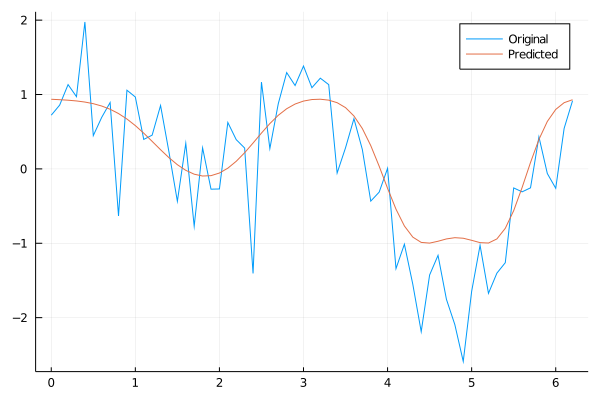

In [28]:
plot(xs, ys, label="Original")
plot!(xs, ex.(xs), label="Predicted")

You can find the corresponding Jupyter notebook in the [Evolutionary](https://github.com/wildart/Evolutionary.jl/tree/master/examples) package repository.